In [4]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame
import numpy as np
from datetime import timedelta
import calendar
data=pd.read_csv('cleaned_data.csv')
data.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0


In [5]:
#Check if the data is stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data['Price'].dropna())
print("p-value: %f" % result[1])


p-value: 0.789687


In [3]:
# Differencing to make the data stationary.
data['Price first difference']= data['Price']-data['Price'].shift(1)
data.dropna(inplace=True)
result_diff = adfuller(data['Price first difference'])
print("p-value after differencing: %f" % result_diff[1])


p-value after differencing: 0.000000


In [4]:
from pandas import DataFrame
import pandas as pd

dataframe = DataFrame()
for i in range(12, 0, -1):
    dataframe['t-' + str(i)] = data['Price'].shift(i)

final_data = pd.concat([data, dataframe], axis=1)
final_data.dropna(inplace=True)


In [5]:
final_data['Date'] = pd.to_datetime(final_data['Date'], format='%Y-%m-%d')
final_data['month'] = final_data['Date'].dt.month

In [6]:
data

,Date,Price,Open,High,Low,Vol.,Change %,Price first difference
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.000,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.000,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.000,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.000,0.0
5,2010-07-23,0.1,0.1,0.1,0.1,2400.0,0.000,0.0
...,...,...,...,...,...,...,...,...
4950,2024-02-05,42697.2,42581.4,43532.2,42272.5,39260.0,0.003,115.8
4951,2024-02-06,43087.7,42697.6,43375.5,42566.8,33320.0,0.009,390.5
4952,2024-02-07,44339.8,43088.4,44367.9,42783.5,48570.0,0.029,1252.1
4953,2024-02-08,45293.3,44346.2,45579.2,44336.4,66380.0,0.022,953.5


In [7]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

finaldf = final_data.drop(['Date'], axis=1)
finaldf = finaldf.reset_index(drop=True)
test_length = 24
end_point = len(finaldf)
x = end_point - test_length
finaldf_train = finaldf.loc[:x - 1, :]
finaldf_test = finaldf.loc[x:, :]
finaldf_test_x = finaldf_test.loc[:, finaldf_test.columns != 'Price']
finaldf_test_y = finaldf_test['Price']
finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'Price']
finaldf_train_y = finaldf_train['Price']
print("Starting model train..")
# Corrected RFE usage
rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), n_features_to_select=4)
fit = rfe.fit(finaldf_train_x, finaldf_train_y)
y_pred = fit.predict(finaldf_test_x)
data.head()

Starting model train..


,Date,Price,Open,High,Low,Vol.,Change %,Price first difference
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,0.0
5,2010-07-23,0.1,0.1,0.1,0.1,2400.0,0.0,0.0


In [8]:
# Accuracy checking
y_true = np.array(finaldf_test_y)
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')

Accuracy: 99.1 %.


Starting model train..
Model train completed..
Model Evaluation: MSE=73543.01035135367, RMSE=271.1881456689316, R²=0.9996820806759849
Creating forecasted set..
Forecast complete..
Forecasted Prices for Next 6 Months: [42350.529999999984, 42755.069000000025, 44084.361, 47185.35400000001, 42184.17099999999, 46893.113]


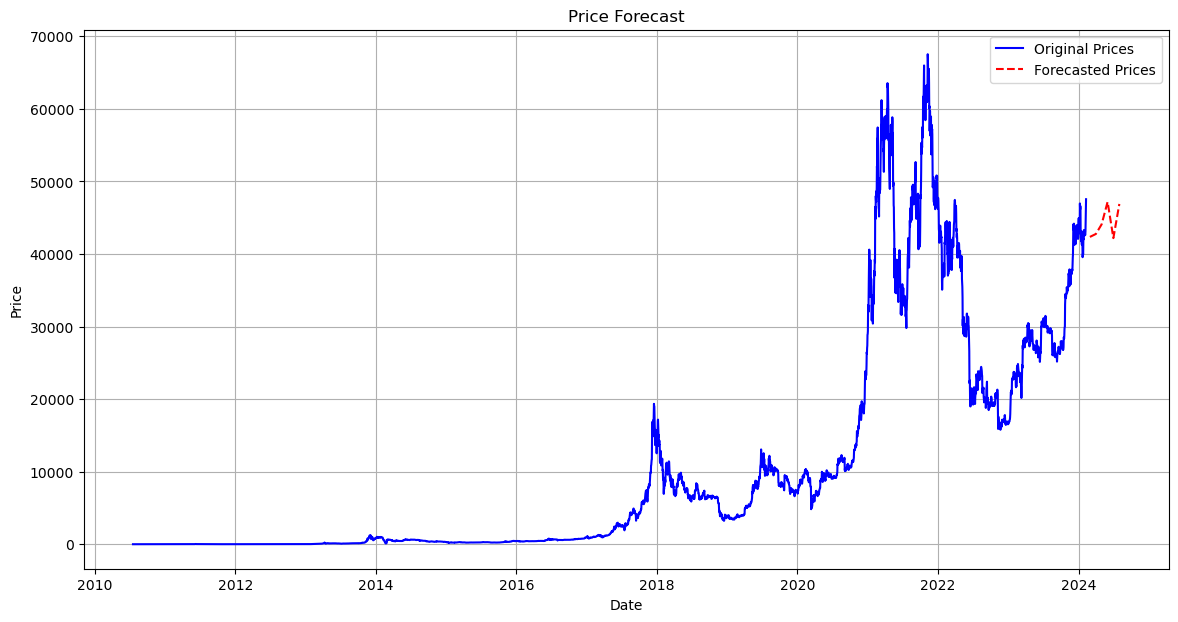

In [2]:
# Full code
import pandas as pd
import numpy as np
from datetime import timedelta
import calendar
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def add_month_mod(df, forecast_length, forecast_period):
    end_point = len(df)
    df1 = pd.DataFrame(index=range(forecast_length), columns=['Price', 'Date'])
    df = pd.concat([df, df1])
    df = df.reset_index(drop=True)
    x = df.at[end_point - 1, 'Date']
    x = pd.to_datetime(x)
    days_in_month = calendar.monthrange(x.year, x.month)[1]
    
    if forecast_period == 'Week':
        df.loc[end_point:, 'Date'] = [x + timedelta(days=7 * i) for i in range(1, forecast_length + 1)]
    elif forecast_period == 'Month':
        df.loc[end_point:, 'Date'] = [x + timedelta(days=days_in_month * i) for i in range(1, forecast_length + 1)]
        
    df['Date'] = pd.to_datetime(df['Date'])
    df['month'] = df['Date'].dt.month
    return df.drop(['Date'], axis=1)

def create_lag_mod(df):
    dataframe = pd.DataFrame()
    for i in range(12, 0, -1):
        dataframe['t-' + str(i)] = df.Price.shift(i)
    df = pd.concat([df, dataframe], axis=1)
    df.dropna(inplace=True)
    return df

def randomForest_fixed(df, forecast_length, forecast_period):
    df = df[['Price', 'Date']]
    df = add_month_mod(df, forecast_length, forecast_period)
    finaldf = create_lag_mod(df)
    finaldf = finaldf.reset_index(drop=True)
    
    # Training and prediction
    x = len(finaldf) - forecast_length
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'Price']
    finaldf_train_y = finaldf_train['Price']
    
    print("Starting model train..")
    rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=1), n_features_to_select=4)
    fit = rfe.fit(finaldf_train_x, finaldf_train_y)
    print("Model train completed..")
    
    # Evaluating the model
    predictions = fit.predict(finaldf_train_x)
    mse = mean_squared_error(finaldf_train_y, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(finaldf_train_y, predictions)
    print(f"Model Evaluation: MSE={mse}, RMSE={rmse}, R²={r2}")
    
    print("Creating forecasted set..")
    yhat = []
    for i in range(forecast_length):
        inputfile = finaldf.loc[len(finaldf) - forecast_length + i:len(finaldf), :]
        inputfile_x = inputfile.loc[:, inputfile.columns != 'Price']
        pred_set = inputfile_x.head(1)
        pred = fit.predict(pred_set)
        df.at[df.index[len(df) - forecast_length + i], 'Price'] = pred[0]
        finaldf = create_lag_mod(df)
        finaldf = finaldf.reset_index(drop=True)
        yhat.append(pred[0])
    
    print("Forecast complete..")
    print("Forecasted Prices for Next 6 Months:", yhat)

    return np.array(yhat)

# Load and prepare the dataset
data = pd.read_csv('cleaned_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Apply the model to the data
predicted_values = randomForest_fixed(data, 6, 'Month')

# Plotting the original and forecasted data
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Price'], label='Original Prices', color='blue')

forecast_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=6, freq='M')
plt.plot(forecast_dates, predicted_values, label='Forecasted Prices', color='red', linestyle='--')

plt.title('Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
